In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# Load waypoints
file_name = "CP_C_F_CCW_1"
# output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line/{file_name}"
output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path/{file_name}"

data_path = os.path.join(output_dir, "pose_waypoints_sampled_10hz_clean.csv")
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv")
plot_2 = False
speed_avg = True

# data_path = os.path.join(output_dir, "pose_waypoints_full.csv")

In [3]:
# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])

# Read the CSV file with a header
with open(data_path_2, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
gt_array_2 = np.array(ground_truth_2)

In [4]:
len(gt_array)

69

In [5]:
## Prediction function, for later
pred_model = 'CTRV'

# Make an empty dataframe to store the error values in next steps
results_df = pd.DataFrame()

In [6]:
## Prediction

# Group data by pedestrian ID (column 1)
pedestrian_ids = np.unique(gt_array[:, 1])
predictions = {}

ph = 1

for ped_id in pedestrian_ids:
    # Filter data for the current pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    
    # Initialize predictions for this pedestrian
    ped_predictions = []
    
    for i in range(0, len(ped_data) - 1 - ph):
        # Extract current and next timestep data
        t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
        t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
        t2, x2, y2 = ped_data[i + 2, 0], ped_data[i + 2, 2], ped_data[i + 2, 3]

        dt1 = t1 - t0
        dt2 = t2 - t1

        # print('dt', dt1, dt2)

        if dt1 == 0 or dt2 == 0:
            print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
            continue  # Avoid divide-by-zero
        
        # Calculate velocity (vx, vy)
        vx1 = (x1 - x0) / dt1
        vy1 = (y1 - y0) / dt1

        vx2 = (x2 - x1) / dt2
        vy2 = (y2 - y1) / dt2

        # Compute headings
        theta1 = np.arctan2(y1 - y0, x1 - x0)
        theta2 = np.arctan2(y2 - y1, x2 - x1)

        print(np.degrees(theta1), np.degrees(theta2))


        # Compute yaw rate and velocity
        dtheta = theta2 - theta1
        dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))  # Normalize
        # print(np.degrees(dtheta))
        omega = dtheta / dt2

        if speed_avg:
            v = (np.sqrt(vx2**2 + vy2**2) + np.sqrt(vx1**2 + vy1**2))/2
        else:
            v = np.sqrt(vx2**2 + vy2**2)


        ### PREDICTION PART ###

        dt = ph * dt2
        
        if abs(omega) > 1e-5:  # Non-zero turn rate
            radius = v / omega
            x_next = x2 + radius * (np.sin(theta2 + omega * dt) - np.sin(theta2))
            y_next = y2 - radius * (np.cos(theta2 + omega * dt) - np.cos(theta2))
        else:  # Straight-line motion
            x_next = x2 + vx2 * dt
            y_next = y2 + vy2 * dt

        # Predict next position assuming constant velocity
        t_next = t2 + dt  # Assuming uniform timestep
        
        # Store the prediction
        ped_predictions.append([t_next, ped_id, x_next, y_next])

    # Store predictions for this pedestrian
    predictions[ped_id] = ped_predictions

p_x = []
p_y = []
# Print predictions for each pedestrian
for ped_id, pred in predictions.items():
    # print(f"Predictions for pedestrian {ped_id}:")
    for p in pred:
        # print(p)
        p_x.append(p[2])
        p_y.append(p[3])

len(p_x)

97.70656183148846 -60.312619896300575
-60.312619896300575 129.32844148267887
129.32844148267887 -41.78253476740303
-41.78253476740303 -148.77640823093301
-148.77640823093301 -156.08822400595488
-156.08822400595488 -155.53774283391613
-155.53774283391613 -156.0042104423099
-156.0042104423099 -95.3332282789044
-95.3332282789044 -175.1548294066215
-175.1548294066215 -167.31435502463282
-167.31435502463282 -138.47202638402456
-138.47202638402456 -131.3988579028208
-131.3988579028208 -170.54954167562994
-170.54954167562994 -12.81581016720634
-12.81581016720634 -76.50789053896908
-76.50789053896908 -154.113873045867
-154.113873045867 -107.42330526533114
-107.42330526533114 -85.8257257995915
-85.8257257995915 -96.5723739638439
-96.5723739638439 -68.34237488390161
-68.34237488390161 70.23511651811816
70.23511651811816 -119.76415003441679
-119.76415003441679 -76.45133749451905
-76.45133749451905 -67.1017736631176
-67.1017736631176 -65.83426584865441
-65.83426584865441 -48.347947592009334
-48.34

67

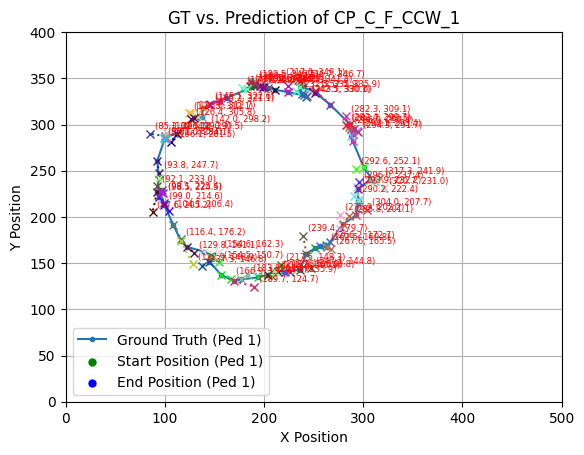

In [7]:
# # Assuming `data_array` and `predictions` are already computed as in the previous code

# # Extract x and y limits for the plot
# x_min, x_max = np.min(data_array[:, 2]), np.max(data_array[:, 2])
# y_min, y_max = np.min(data_array[:, 3]), np.max(data_array[:, 3])

# # Create the combined plot
# plt.figure(figsize=((x_max - x_min) * 0.5, (y_max - y_min) * 0.5), dpi=300)

# Set the x and y axis limits
plt.xlim(0, 500)
plt.ylim(0, 400)

pedestrian_ids = np.unique(gt_array[:, 1])

# Plot ground truth trajectory (blue)
for ped_id in pedestrian_ids:
    # Filter ground truth data for the pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    ped_data_2 = gt_array_2[gt_array_2[:, 1] == ped_id]

    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    x_gt_2, y_gt_2 = ped_data_2[:, 2], ped_data_2[:, 3]
    
    # Plot ground truth trajectory
    plt.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3,
             label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)
    
    if plot_2:
        plt.plot(x_gt_2, y_gt_2, marker="*", linestyle="-", markersize=3,
            label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)

    ## Plot predicted trajectory

    # Connect ground truth to prediction

    if ped_id in predictions:
        j = 2
        for pred in predictions[ped_id]:
            t_pred, ped_id_pred, x_pred, y_pred = pred
            plt.text(x_pred + 5, y_pred + 5, f"({x_pred:.1f}, {y_pred:.1f})", fontsize=6, color="red")
            plt.plot([x_gt[j], x_pred], [y_gt[j], y_pred], color=np.random.rand(3,),
                     marker="x", linestyle='dotted')
            j += 1

            # Othe types of plots can be added here, but be careful about multiple labels. It's better for the multi-step predictions, I think


    
    # plt.plot(p_x, p_y, marker="x", linewidth=1, linestyle='--', label='Predicted Positions', color="red") # Connect all prediction to each other
    # plt.scatter(p_x, p_y, marker="x", label='Predicted Positions', color="red") # Just show the predicted positions

# Mark start and end positions
for ped_id in np.unique(gt_array[:, 1]):
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    plt.scatter(x_gt[0], y_gt[0], color="green", s=25, label=f"Start Position (Ped {int(ped_id)})")
    plt.scatter(x_gt[-1], y_gt[-1], color="blue", s=25, label=f"End Position (Ped {int(ped_id)})")
    
# plt.gca().invert_yaxis()  # Invert Y to match video coordinates
# plt.gca().invert_xaxis()  # Invert X to match video coordinates

# Titles and labels
plt.title(f"GT vs. Prediction of {file_name}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.close()

In [8]:
error_ade = []
error_ade_normal = []

# Calculate ADE
i = 0
for _, _, x, y in ground_truth[2 + ph:]:
        pred = np.array((p_x[i], p_y[i]))
        gt = np.array((x, y))

        dist = np.linalg.norm(pred - gt, axis=-1)
        print('*********', pred, gt, dist)
        error_ade.append(dist)

        # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.

        steps_size = 0
        for j in range(1, ph + 1):
            step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
            step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

            steps_size += np.linalg.norm(step_end - step_start, axis=-1)

        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

        error_ade_normal.append(dist / steps_size)
        
        i += 1

ade_avg = np.average(error_ade)
print('Average prediction error: {:.2f}'.format(ade_avg))

ade_avg_normal = np.average(error_ade_normal)
print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

********* [186.08133139 341.93089448] [188.60494995 345.56021118] 4.420473997434132
********* [189.53072478 346.45888504] [191.30908203 343.1439209 ] 3.7618535077537936
********* [190.2383459  341.74031212] [182.90797424 338.05130005] 8.206287756388413
********* [178.03166931 340.04856883] [162.48025513 328.99395752] 19.080118296099855
********* [145.09779469 322.57920666] [155.44894409 325.79519653] 10.839228982061314
********* [145.17602786 321.06203502] [138.34838867 318.18304443] 7.409807262428371
********* [124.48033976 312.0773291 ] [137.40113831 308.03598022] 13.538077253773642
********* [141.97121815 298.23642282] [133.89346313 307.73864746] 12.471663849369905
********* [126.80424103 312.71468572] [129.60751343 306.77389526] 6.568966994730243
********* [126.38057212 305.81154154] [120.11624908 298.36846924] 9.72836411031135
********* [114.77869359 290.47035059] [112.31310272 289.5171814 ] 2.6434200992191266
********* [106.10210293 281.52795382] [ 99.93254852 287.45639038] 8.556

In [ ]:
# # Define file names and data paths
# file_names = ["DL_C_F_BRTL_1", "DL_C_F_BRTL_2", "DL_C_F_BRTL_3", "DL_C_F_BRTL_4", "DL_C_F_BRTL_5", "DL_C_F_BRTL_6"]
# data_files = ["pose_waypoints_sampled_10hz_clean.csv", "pose_waypoints_sampled_2.5hz_clean.csv", "pose_waypoints_full_clean.csv"]

# Directory for datasets
base_dir = "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line"
# base_dir = '/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop'

# Placeholder for results
results = []

# Loop through file names and data files
for root, dirs, files in os.walk(base_dir):

    dataset_name = root.split("/")[-1]
    if dataset_name.startswith('x_'):
        continue

    for file in files:

        if file.endswith("_raw.csv") or not file.endswith("_2.5hz_clean.csv"):
            continue
        
        data_path = os.path.join(root, file)

        # Load data and calculate prediction error
        try:
            # Parse ground truth data
            ground_truth = []

            # Read the CSV file with a header
            with open(data_path, "r") as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                    
            gt_array = np.array(ground_truth)

            # Group data by pedestrian ID (column 1)
            pedestrian_ids = np.unique(gt_array[:, 1])
            predictions = {}

            ph = 1

            for ped_id in pedestrian_ids:
                # Filter data for the current pedestrian
                ped_data = gt_array[gt_array[:, 1] == ped_id]
                
                # Initialize predictions for this pedestrian
                ped_predictions = []
                
                for i in range(0, len(ped_data) - 1 - ph):
                    # Extract current and next timestep data
                    t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                    t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                    t2, x2, y2 = ped_data[i + 2, 0], ped_data[i + 2, 2], ped_data[i + 2, 3]
                    
                    dt1 = t1 - t0
                    dt2 = t2 - t1

                    if dt1 == 0 or dt2 == 0:
                        print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
                        continue  # Avoid divide-by-zero
                    
                    # Calculate velocity (vx, vy)
                    vx1 = (x1 - x0) / dt1
                    vy1 = (y1 - y0) / dt1

                    vx2 = (x2 - x1) / dt2
                    vy2 = (y2 - y1) / dt2

                    # Compute headings
                    theta1 = np.arctan2(y1 - y0, x1 - x0)
                    theta2 = np.arctan2(y2 - y1, x2 - x1)

                    # Compute yaw rate and velocity
                    dtheta = theta2 - theta1
                    dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))  # Normalize
                    omega = dtheta / dt2

                    v = np.sqrt(vx2**2 + vy2**2)

                    ### PREDICTION PART ###

                    dt = ph * dt2

                    if abs(omega) > 1e-5:  # Non-zero turn rate
                        radius = v / omega
                        x_next = x2 + radius * (np.sin(theta2 + omega * dt) - np.sin(theta2))
                        y_next = y2 - radius * (np.cos(theta2 + omega * dt) - np.cos(theta2))
                    else:  # Straight-line motion
                        x_next = x2 + vx2 * dt
                        y_next = y2 + vy2 * dt

                    # Predict next position assuming constant velocity
                    t_next = t2 + dt  # Assuming uniform timestep
        
                    # Store the prediction
                    ped_predictions.append([t_next, ped_id, x_next, y_next])
                    
                # Store predictions for this pedestrian
                predictions[ped_id] = ped_predictions

            p_x = []
            p_y = []
            # Print predictions for each pedestrian
            for ped_id, pred in predictions.items():
                # print(f"Predictions for pedestrian {ped_id}:")
                for p in pred:
                    # print(p)
                    p_x.append(p[2])
                    p_y.append(p[3])

            
            error_ade = []
            error_ade_normal = []

            # Calculate ADE
            i = 0
            for _, _, x, y in ground_truth[2 + ph:]:
                    pred = np.array((p_x[i], p_y[i]))
                    gt = np.array((x, y))

                    dist = np.linalg.norm(pred - gt, axis=-1)
                    
                    error_ade.append(dist)


                    # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.
        
                    steps_size = 0
                    for j in range(1, ph + 1):
                        step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
                        step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

                        steps_size += np.linalg.norm(step_end - step_start, axis=-1)

                    # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                    # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
                    # step_size = np.linalg.norm(step_end - step_start, axis=-1)

                    error_ade_normal.append(dist / steps_size)

                    i += 1

            
            ade_avg = np.average(error_ade)
            # print('Average prediction error: {:.2f}'.format(ade_avg))

            ade_avg_normal = np.average(error_ade_normal)
            # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

            
            # Append result
            results.append({
                "dataset_name": dataset_name,
                "path_type": dataset_name[:4],
                "acceleration_type": dataset_name.split("_")[2],
                "path_direction": dataset_name.split("_")[3],
                "path_number": dataset_name.split("_")[4],
                "sample_rate": file.split("_")[-2],
                "ph": ph,
                "prediction_model": pred_model,
                "average_error": ade_avg,
                "average_error_normal": ade_avg_normal
            })

            # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
        except Exception as e:
            print(f"Error processing {dataset_name} with {file}: {e}")

# Display results
for result in results:
    print(result)

In [16]:
speed_avg = False

# Directories for datasets
base_dirs = [
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Horizontal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Diagonal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Square Path",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path"
]

results = []

for base_dir in base_dirs:
    for root, dirs, files in os.walk(base_dir):

        dataset_name = root.split("/")[-1]
        if dataset_name.startswith('x_'):
            continue

        for file in files:

            if file.endswith("_raw.csv") or file.endswith("_2.5hz_clean.csv"):
                continue
            
            data_path = os.path.join(root, file)

            # Load data and calculate prediction error
            try:
                # Parse ground truth data
                ground_truth = []

                # Read the CSV file with a header
                with open(data_path, "r") as csvfile:
                    reader = csv.DictReader(csvfile)
                    for row in reader:
                        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                        
                gt_array = np.array(ground_truth)

                # Group data by pedestrian ID (column 1)
                pedestrian_ids = np.unique(gt_array[:, 1])
                predictions = {}

                ph = 4

                for ped_id in pedestrian_ids:
                    # Filter data for the current pedestrian
                    ped_data = gt_array[gt_array[:, 1] == ped_id]
                    
                    # Initialize predictions for this pedestrian
                    ped_predictions = []
                    
                    for i in range(0, len(ped_data) - 1 - ph):
                        # Extract current and next timestep data
                        t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                        t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                        t2, x2, y2 = ped_data[i + 2, 0], ped_data[i + 2, 2], ped_data[i + 2, 3]
                        
                        dt1 = t1 - t0
                        dt2 = t2 - t1

                        if dt1 == 0 or dt2 == 0:
                            print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
                            continue  # Avoid divide-by-zero
                        
                        # Calculate velocity (vx, vy)
                        vx1 = (x1 - x0) / dt1
                        vy1 = (y1 - y0) / dt1

                        vx2 = (x2 - x1) / dt2
                        vy2 = (y2 - y1) / dt2

                        # Compute headings
                        theta1 = np.arctan2(y1 - y0, x1 - x0)
                        theta2 = np.arctan2(y2 - y1, x2 - x1)

                        # Compute yaw rate and velocity
                        dtheta = theta2 - theta1
                        dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))  # Normalize
                        omega = dtheta / dt2

                        if speed_avg:
                            v = (np.sqrt(vx2**2 + vy2**2) + np.sqrt(vx1**2 + vy1**2))/2
                        else:
                            v = np.sqrt(vx2**2 + vy2**2)

                        ### PREDICTION PART ###

                        dt = ph * dt2

                        if abs(omega) > 1e-5:  # Non-zero turn rate
                            radius = v / omega
                            x_next = x2 + radius * (np.sin(theta2 + omega * dt) - np.sin(theta2))
                            y_next = y2 - radius * (np.cos(theta2 + omega * dt) - np.cos(theta2))
                        else:  # Straight-line motion
                            x_next = x2 + vx2 * dt
                            y_next = y2 + vy2 * dt

                        # Predict next position assuming constant velocity
                        t_next = t2 + dt  # Assuming uniform timestep
            
                        # Store the prediction
                        ped_predictions.append([t_next, ped_id, x_next, y_next])
                        
                    # Store predictions for this pedestrian
                    predictions[ped_id] = ped_predictions

                p_x = []
                p_y = []
                # Print predictions for each pedestrian
                for ped_id, pred in predictions.items():
                    # print(f"Predictions for pedestrian {ped_id}:")
                    for p in pred:
                        # print(p)
                        p_x.append(p[2])
                        p_y.append(p[3])

                
                error_ade = []
                error_ade_normal = []

                # Calculate ADE
                i = 0
                for _, _, x, y in ground_truth[2 + ph:]:
                        pred = np.array((p_x[i], p_y[i]))
                        gt = np.array((x, y))

                        dist = np.linalg.norm(pred - gt, axis=-1)
                        
                        error_ade.append(dist)


                        # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.
            
                        steps_size = 0
                        for j in range(1, ph + 1):
                            step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
                            step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

                            steps_size += np.linalg.norm(step_end - step_start, axis=-1)

                        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
                        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

                        error_ade_normal.append(dist / steps_size)

                        i += 1

                
                ade_avg = np.average(error_ade)
                # print('Average prediction error: {:.2f}'.format(ade_avg))

                ade_avg_normal = np.average(error_ade_normal)
                # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

                
                # Append result
                results.append({
                    "dataset_name": dataset_name,
                    "path_type": dataset_name[:4],
                    "acceleration_type": dataset_name.split("_")[2],
                    "path_direction": dataset_name.split("_")[3],
                    "path_number": dataset_name.split("_")[4],
                    "sample_rate": file.split("_")[-2],
                    "ph": ph,
                    "prediction_model": pred_model,
                    "speed_avg": speed_avg,
                    "average_error": ade_avg,
                    "average_error_normal": ade_avg_normal
                })

                # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
            except Exception as e:
                print(f"Error processing {dataset_name} with {file}: {e}")

In [17]:
# Remove duplicate rows based on all columns and keep the last occurrence
results_df = pd.concat([results_df, pd.DataFrame(results)]).drop_duplicates(keep='last').reset_index(drop=True)
# df_filtered = results_df[results_df['data_file'].str.endswith('2.5hz_clean.csv')]

# Display the DataFrame
results_df
# df_filtered


,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,speed_avg,average_error,average_error_normal
0,VL_C_F_TD_3,VL_C,F,TD,3,full,1,CTRV,True,4.570776,2.416931
1,VL_C_F_TD_3,VL_C,F,TD,3,2.5hz,1,CTRV,True,29.713660,0.663119
2,VL_C_F_TD_3,VL_C,F,TD,3,10hz,1,CTRV,True,11.672355,1.956156
3,VL_C_F_BU_5,VL_C,F,BU,5,full,1,CTRV,True,4.585323,1.036047
4,VL_C_F_BU_5,VL_C,F,BU,5,2.5hz,1,CTRV,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1025,CP_C_F_CCW_2,CP_C,F,CCW,2,10hz,4,CTRV,False,46.183334,1.114731
1026,CP_C_F_CCW_3,CP_C,F,CCW,3,full,4,CTRV,False,19.817525,0.927410
1027,CP_C_F_CCW_3,CP_C,F,CCW,3,10hz,4,CTRV,False,51.263852,1.056049
1028,CP_C_A_CW_1,CP_C,A,CW,1,full,4,CTRV,False,22.778492,0.972178


In [18]:
results_df.to_csv("results_df.csv", index=False)

In [20]:
results_df_filtered = results_df[
    (results_df['sample_rate'].isin(['2.5hz'])) & 
    (results_df['ph'] == 1) & 
    (results_df['acceleration_type'] == 'F') &
    (results_df['path_type'] == 'CP_C')
    ]

results_df_filtered
# results_df.groupby([
#     'path_type',
#     # 'acceleration_type',
#     'sample_rate'
#                     ]).agg({'average_error': ['mean', 'std'],
#     'average_error_normal': ['mean', 'std']}).reset_index()

,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,speed_avg,average_error,average_error_normal
268,CP_C_F_CW_1,CP_C,F,CW,1,2.5hz,1,CTRV,True,22.576600,0.682508
271,CP_C_F_CCW_1,CP_C,F,CCW,1,2.5hz,1,CTRV,True,23.839219,0.831636
274,CP_C_F_CCW_111,CP_C,F,CCW,111,2.5hz,1,CTRV,True,44.401035,0.593480
283,CP_C_F_CW_4,CP_C,F,CW,4,2.5hz,1,CTRV,True,24.190936,0.610605
286,CP_C_F_CW_3,CP_C,F,CW,3,2.5hz,1,CTRV,True,21.045529,0.600733
289,CP_C_F_CW_2,CP_C,F,CW,2,2.5hz,1,CTRV,True,20.106997,0.457284
301,CP_C_F_CCW_2,CP_C,F,CCW,2,2.5hz,1,CTRV,True,23.470837,0.873554
304,CP_C_F_CCW_3,CP_C,F,CCW,3,2.5hz,1,CTRV,True,32.952603,0.678678
577,CP_C_F_CW_1,CP_C,F,CW,1,2.5hz,1,CTRV,False,24.274842,0.724972
580,CP_C_F_CCW_1,CP_C,F,CCW,1,2.5hz,1,CTRV,False,27.712740,0.947511
